In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\reklamacje\\'


# read data

In [2]:
def func_read_data(path):
    df=pd.read_csv(path+'.csv',
              encoding='Cp1250',
              sep="|")
    if 'IS_DELETED' in df.columns:
        df=df.loc[df['IS_DELETED']=='N']
    return df
def func_numer_faktury(df):
    df['FAKTURA_NUMER']=df['FAKTURA'].apply(lambda x: x[4:])
    return df
    
def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_add_time(df):
    
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

def func_add_kod_fili(df, col_kod):
    df_filia=pd.read_csv('../słowniki/filie.csv',
                         encoding='Cp1250',
                          sep="|")
    df_filia=df_filia.loc[df_filia['IS_DELETED']=='N'][['KOD','ANALIT01','ANALIT02']]
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT01']='LI'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT02']='LIKWIDACJA'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT01']='00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT02']='MAGAZYN_00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT01']='FE'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT02']='FELER'
    df=df.merge(df_filia, how='left', left_on=col_kod, right_on='KOD')
    return df

def func_add_slownik(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','ZNACZNIK','DOSTAWCA', 'TRZY']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    df=func_add_znacznik(df)
    return df

def func_add_znacznik(df):
    df_znacznik=pd.read_csv('../słowniki/znacznik.csv',
                            encoding='Cp1250',
                              sep="|")
    df_znacznik=df_znacznik.loc[df_znacznik['IS_DELETED']=='N'][['ZNACZNIK','NAZWA']]
    df_znacznik=df_znacznik.rename(columns={'NAZWA':'NAZWA_ZNACZNIK'})
    df=df.merge(df_znacznik, how='left', on='ZNACZNIK')
    return df

def func_slownik_nazwa_rodzaj(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','NAZWA','RODZAJ']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    return df

def func_sell(path):
    df=pd.read_csv('../sprzedaz_fakty_bi/'+path+'.csv',
                            encoding='Cp1250',
                              sep="|")
    df=func_add_slownik(df)
    df=func_add_time(df)
    df['WARTOB_SUM_NETTO_HURT']=func_str_to_float(df['WARTOB_SUM_NETTO_HURT'])
    df['WARTOBB_SUM_BRUTTO_HURT']=func_str_to_float(df['WARTOBB_SUM_BRUTTO_HURT'])
    df['WARTSN_SUM_NETTO_SALON']=func_str_to_float(df['WARTSN_SUM_NETTO_SALON'])
    df['WARTSB_SUM_BRUTTO_SALON']=func_str_to_float(df['WARTSB_SUM_BRUTTO_SALON'])
    df['ILOSC_SUM']=func_str_to_float(df['ILOSC_SUM'])
    df=func_add_kod_fili(df, 'FILIA')
    return df

def func_nazwa_szac(df):
    df['NAZWA1_BEZ_F']=df['NAZWA1'].apply(lambda x: x[2:] if x[:2]=='F/' else x)
    return df

In [3]:
def func_przeliczenie_belek(df, ilosc):
    df_belki=df.loc[df['NAZWA_ZNACZNIK']=='BELKI']
    df_belki['ILOSC_NEW']=1
    df_inne=df.loc[df['NAZWA_ZNACZNIK']!='BELKI']
    df_inne['ILOSC_NEW']=df_inne[ilosc]
    return df_belki.append(df_inne)

In [4]:
df_sell=func_sell('hurtbi_fakty_sprz_22_2')
df_sell=df_sell.loc[df_sell['TYP_DOK'].str.contains('F')]
df_sell=df_sell.loc[df_sell['Z_DNIA']<np.datetime64('2022-07-01')]

ilosc belek przeliczyc na pozycje!
i rzucić na bgc

In [5]:
df_fi=func_read_data('f56fi_wszystkie_kody_fili_cena_pozycja')
df_fi=func_numer_faktury(df_fi)
df_fi=func_add_slownik(df_fi)
df_fi=func_add_time(df_fi)
df_fi['WARTOSC_B']=func_str_to_float(df_fi['WARTOSC_B'])
df_fi['ILOSC']=func_str_to_float(df_fi['ILOSC'])
df_fi['CENA_POZYCJA']=func_str_to_float(df_fi['CENA_POZYCJA'])
df_fi=func_add_kod_fili(df_fi, 'KOD')

df_fi=df_fi.loc[df_fi['Z_DNIA']<np.datetime64('2022-07-01')]

In [6]:
df_szac=func_read_data('f56szac')
df_szac=func_numer_faktury(df_szac)
df_szac=func_add_slownik(df_szac)
df_szac=func_add_time(df_szac)
df_szac['CENA_Z1']=func_str_to_float(df_szac['CENA_Z1'])
df_szac['CENA_Z2']=func_str_to_float(df_szac['CENA_Z2'])
df_szac=func_nazwa_szac(df_szac)

df_szac=df_szac.loc[df_szac['Z_DNIA']<np.datetime64('2022-07-01')]

In [6]:
df_fi.groupby(['ANALIT01','ANALIT02']).agg({'FAKTURA':'nunique',
                                           'CENA_POZYCJA':'sum'}).sort_values(by='FAKTURA').reset_index().to_excel(path_to_catalog+'tabele_wyniki/'+'cena_pozycji_liczba_faktur_FI.xlsx')

In [7]:
df_ff=func_read_data('f56ff11_22')
df_ff=func_add_time(df_ff)
df_ff['WARTOSC_B']=func_str_to_float(df_ff['WARTOSC_B'])
df_ff['kanal_dystrybucji']=df_ff['DOKUMENT'].apply(lambda x: x[4:6])
df_ff=func_add_kod_fili(df_ff, 'KOD')
df_ff=df_ff.loc[df_ff['Z_DNIA']<=np.datetime64('2022-07-01')]
#df_ff=func_add_kod_fili(df_ff, 'kanal_dystrybucji')

In [8]:
df_sell=func_przeliczenie_belek(df_sell, 'ILOSC_SUM')
df_fi=func_przeliczenie_belek(df_fi, 'ILOSC')

# ploty i przeliczenia

## big view

In [9]:
def func_big_view(df, group, save, filia_00):
    df_small=df.groupby(group).agg({'FAKTURA':'nunique',
                                        'ILOSC_NEW':'sum',
                                        'CENA_POZYCJA':'sum'}).sort_values(by='CENA_POZYCJA')
    df_small['ILOSC_NEW']=round(df_small['ILOSC_NEW'], 1)
    df_small['CENA_POZYCJA']=round(df_small['CENA_POZYCJA'], 1)
    df_big=df.agg({'FAKTURA':'nunique',
                                        'ILOSC_NEW':'sum',
                                        'CENA_POZYCJA':'sum'})
    for i in df_small.columns:
        df_small[i+'_proc']=round(df_small[i]/df_big[i]*100, 1)
    
    if len(group)==1:
        fig=make_subplots(1, 3, subplot_titles=[i for i in df_small.columns if 'proc' in i],
                          start_cell ='bottom-left',
                         specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
        for i, col in enumerate([i for i in df_small.columns if 'proc' in i]):
            fig.add_trace(go.Pie(labels=df_small.index,
                                 values=df_small[col],
                                 scalegroup='one'),
                          1, i+1)

        # fig=px.pie(df_small,
        #           values=co_plotowac,
        #           names=df_small.index,
        #           width=300)
        fig.update_traces(textposition='inside', textinfo='percent')
        
    else:
        fig = px.treemap(df_small.loc[df_small['CENA_POZYCJA_proc']!=0].reset_index(), path=group, values='CENA_POZYCJA_proc', hover_data=['CENA_POZYCJA'],
                        height=600)
        fig.data[0].textinfo = 'label+value+percent parent'
        
        
    if save=='zapisz':
        fig.write_html(path_to_catalog+'wykres_'+'_'.join(group)+'_'+filia_00+'.html')
        df_small.to_excel(path_to_catalog+'tabele_wyniki\\zestawienie_big_view_'+'_'.join(group)+'_'+filia_00+'.xlsx')
        
    else:
        fig.show()
        return df_small

In [11]:
func_big_view(df_fi, ['ANALIT01'],
             'zapisz', 'plus_filia_00')
func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['ANALIT01'],
             'zapisz', 'bez_filia_00')

In [13]:
func_big_view(df_fi, ['NAZWA_ZNACZNIK'],
             'zapisz', 'plus_filia_00')
func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['NAZWA_ZNACZNIK'],
             'zapisz', 'bez_filia_00')

In [14]:

func_big_view(df_fi, ['ANALIT01','NAZWA_ZNACZNIK'],
             'zapisz', 'plus_filia_00')
func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['ANALIT01','NAZWA_ZNACZNIK'],
             'zapisz', 'bez_filia_00')

## ploty na dostawce/znacznik

In [66]:
df_fi.groupby(['ANALIT02']).agg({'FAKTURA':'nunique'}).sort_values(by='FAKTURA', ascending=False).to_excel(path_to_catalog+'tabele_wyniki/unikatowe_dokumenty_z_FI.xlsx')

In [42]:
def func_plot_scatter(df, dict_agg, gr,
                     df_sell,
                     jaka_ilosc):
    df_sell=df_sell.loc[df_sell['ILOSC_SUM']>=1]
    df=df.loc[df['ANALIT01'].isin(['LI','FE', 'OU'])]
    df_dostawca_produkt=df[['DOSTAWCA','KOD_TEMA']].drop_duplicates()
    df_gr_filtr=df[[gr]].drop_duplicates()
    df_gr=df.groupby(gr).agg(dict_agg).sort_values(by=jaka_ilosc, ascending=False).reset_index()
    df_sell_dostawca_produkt=df_sell.merge(df_dostawca_produkt, how='inner', on=list(df_dostawca_produkt.columns)).\
                                    groupby(gr).agg({'WARTSB_SUM_BRUTTO_SALON':'sum'}).reset_index()
    df_sell=df_sell.merge(df_gr_filtr, how='inner', on=list(df_gr_filtr.columns)).\
                    groupby(gr).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                    'ILOSC_SUM':'sum'}).reset_index()
    df_gr=df_gr.merge(df_sell, how='inner', on=gr)
    df_gr['proc']=df_gr[jaka_ilosc]/df_gr['ILOSC_SUM']*100
    df_gr.sort_values(by='proc').to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_'+gr+'.xlsx')
    df_gr=round(df_gr,1)
    if gr=='NAZWA_ZNACZNIK':
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                  x=gr,
                  y=jaka_ilosc,
                   color='CENA_POZYCJA',
                   size='proc',
                   color_continuous_scale=["red", "green", "blue"],
                  #color='NAZWA_ZNACZNIK',
                  height=600,
                  hover_name=gr, 
                    #hover_data={"proc":'%{text:.2s}'},
                    text='CENA_POZYCJA',
                  size_max=60)#,
                  #log_y=True)
    else:
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                      x=gr,
                      y=jaka_ilosc,
                       color='CENA_POZYCJA',
                       #size='proc',
                       color_continuous_scale=["red", "green", "blue"],
                      #color='NAZWA_ZNACZNIK',
                      height=600,
                      hover_name=gr, hover_data=['proc'])
                      #size_max=60)#,
                      #log_y=True)
    fig.update_layout(hovermode="x")
    fig.update_traces(texttemplate='%{text:.2s}', textposition='top center')
    fig.show()
    
    _=df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100
    _=_.rename(columns={jaka_ilosc:'ILOSC_PROCENT',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT'})
    _1=(df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100).cumsum()
    _1=_1.rename(columns={jaka_ilosc:'ILOSC_PROCENT_NARASTAJACY',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT_NARASTAJACY'})
    df_gr[[gr]].merge(_, how='left', left_index=True, right_index=True).merge(_1, how='left', left_index=True, right_index=True).\
        to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_pareto_ilosc_'+gr+'.xlsx')
    # display(df_sell_dostawca_produkt)
    # display(df_sell)
    fig.write_html(path_to_catalog+gr+'.html')
    return

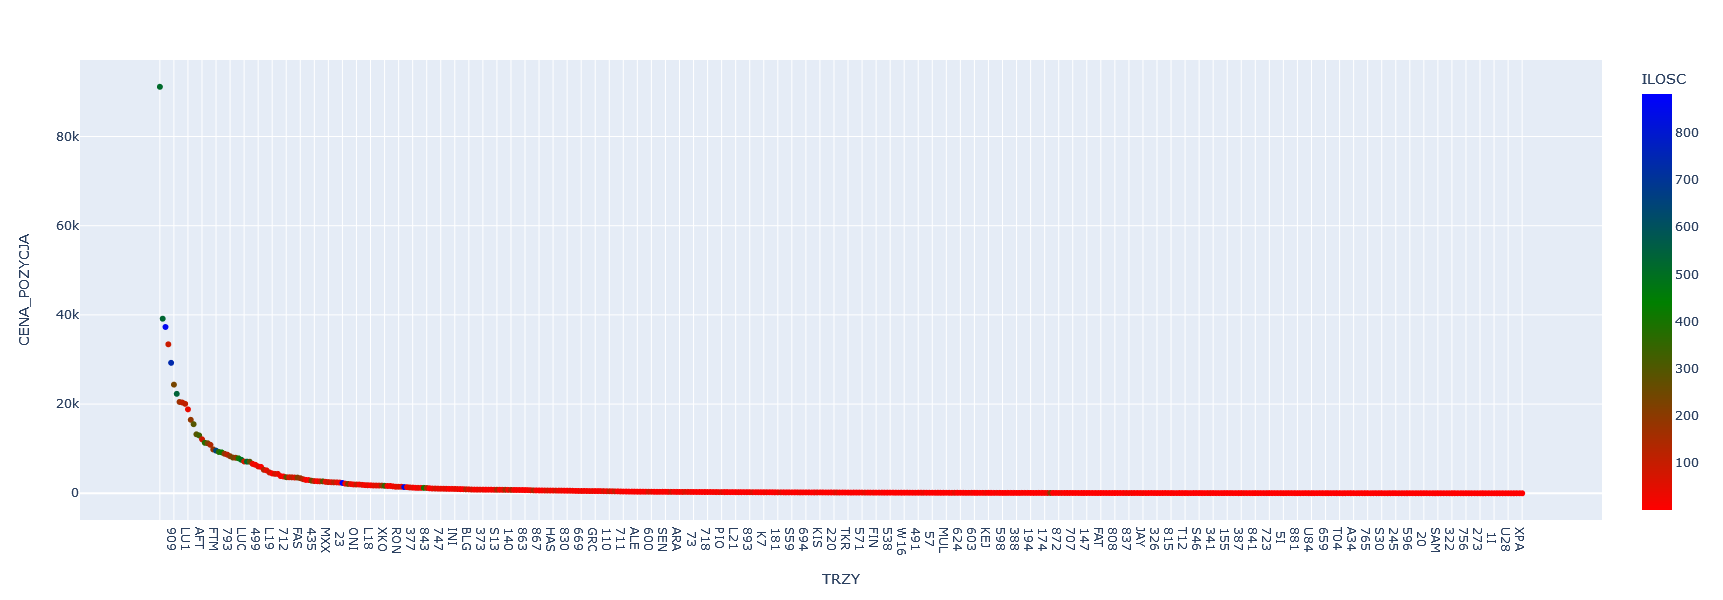

In [16]:
func_plot_scatter(df_fi, {'ILOSC':'sum',
                         'CENA_POZYCJA':'sum'},
                  'TRZY',
                 df_sell)

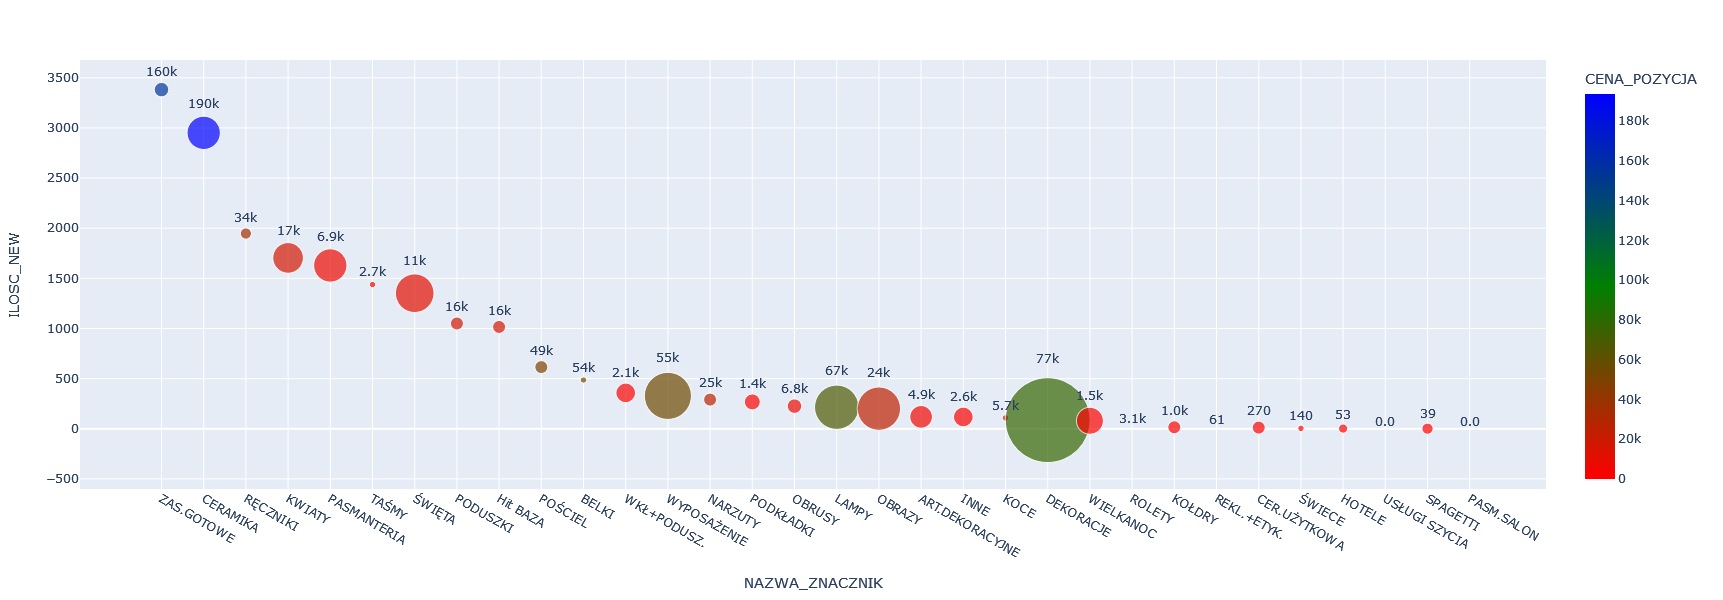

In [43]:
func_plot_scatter(df_fi, {'ILOSC_NEW':'sum',
                         'CENA_POZYCJA':'sum'}, 
                  'NAZWA_ZNACZNIK',
                 df_sell,
                 'ILOSC_NEW')

In [31]:
df_fi.groupby(['NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                      'CENA_POZYCJA':'sum',
                                      'FAKTURA':['count','nunique']}).sort_values(by=(       'ILOSC',     'sum'),
                                                                                 ascending=False)

ILOSC  CENA_POZYCJA FAKTURA        
                      sum           sum   count nunique
NAZWA_ZNACZNIK                                         
ZAS.GOTOWE       75269.00  4.832258e+06   25798   13121
ŚWIĘTA           18188.00  1.774523e+05    2576     408
PODUSZKI         13974.00  2.736027e+05    6023    1961
BELKI            12532.67  3.497766e+05    1327     595
RĘCZNIKI         10022.00  2.351767e+05    4391    1566
POŚCIEL           7629.20  8.076059e+05    5040    1950
TAŚMY             7294.00  1.915372e+04      64      49
CERAMIKA          5885.00  3.794656e+05    4488    1769
NARZUTY           5396.00  6.492777e+05    3794    1950
Hit BAZA          4289.25  7.945910e+04     363     211
KWIATY            3650.00  5.095447e+04     593     177
OBRUSY            3609.00  1.777755e+05    1943     602
PASMANTERIA       3006.39  2.889673e+04     584     181
KOCE              1913.00  1.480930e+05    1203     638
WKŁ+PODUSZ.       1682.00  1.060744e+04     166     117
PODKŁADKI         1338.00  9.889244e+03     330     193
WYPOSAŻENIE        796.00  1.729537e+05     572     437
OBRAZY             778.00  1.197735e+05     706     266
KARNISZE           669.00  9.685389e+02      21      10
LAMPY              583.00  2.021065e+05     477     325
DOD.KRAWIECKIE     560.00  9.643200e+02       9       7
ART.DEKORACYJNE    282.00  1.757168e+04     124      76
ROLETY             221.96  3.457173e+04     161      38
INNE               146.00  3.876148e+03      67      58
WIELKANOC          134.00  2.291650e+03      69      34
DEKORACJE          111.41  9.943373e+04      93      50
KOŁDRY             105.00  9.493866e+03      65      48
HOTELE              56.00  2.672692e+03      16       9
CER.UŻYTKOWA        21.00  3.002073e+03      17      12
ŚWIECE              21.00  9.532869e+02      13      10
REKL.+ETYK.         15.00  7.559580e+01       5       5
USŁUGI SZYCIA        4.00  4.052112e+02       3       3
ROL+PLISY            2.00  2.307480e+01       1       1
SPAGETTI             1.00  3.874500e+01       1       1
PASM.SALON           1.00  0.000000e+00       1       1

## ploty dla znacznikow po dostawcach

In [7]:
if 'sprzedaz_calego_dostawcy' in df_fi:
    pass
else:
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby('DOSTAWCA').agg(sprzedaz_calego_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_calego_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','NAZWA_ZNACZNIK']).agg(sprzedaz_znacznik_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_znacznik_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','NAZWA_ZNACZNIK'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','KOD_TEMA']).agg(sprzedaz_kod_tema_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_kod_tema_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','KOD_TEMA'])

In [8]:
df_fi=df_fi.fillna(0)

In [9]:
df_fi_sell=df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
    groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK','RODZAJ','KOD_TEMA']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'nunique',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index().\
        groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'sum',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index()

# df_fi_sell=df_fi_sell.merge(df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
#                                 groupby(['FAKTURA','ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'first'}).reset_index().\
#                                 groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'sum'}).reset_index(),
#                             how='left',
#                             on=['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK'])

In [10]:
from sklearn.cluster import KMeans

In [11]:
from sklearn.metrics import silhouette_score
def func_choose_k(x):
    sil = []
    kmax = 6
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    plt.plot(range(2, kmax+1), sil)
    plt.show()

    
def func_odwroc_pred(x, x_centers):
    if x_centers[0][1]>x_centers[1][1]:
        return x
    else:
        for i in range(0,len(x)):
            if x[i]==0:
                x[i]=1
            else:
                x[i]=0
        return x
    
    
def func_cluster(df, znacznik, gdzie, plot=1):
    if znacznik!='':
        df=df.loc[df['NAZWA_ZNACZNIK']==znacznik]
        df=df.loc[df['ANALIT02']==gdzie]
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df['proc_reklamacji_do_znacznik_dostawca']=df['ILOSC']/df['sprzedaz_znacznik_dostawcy_ilosc']*100
        #display(df.sort_values(by='proc_reklamacji_do_znacznik_dostawca'))
        try:
            kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            #print(kmeans.labels_, kmeans.cluster_centers_)
            x_pred=func_odwroc_pred(x_pred, kmeans.cluster_centers_)
            df['pred_cluster']=x_pred
            df['pred_cluster']=df['pred_cluster'].astype(str)
            if plot:
                fig=px.scatter(df,
                               x='ILOSC',
                               color='CENA_POZYCJA',
                               y='proc_reklamacji_do_znacznik_dostawca',
                              color_continuous_scale=["red", "green", "blue"])#px.colors.sequential.solar_r)
                fig.show()
                func_choose_k(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
                
            return df[['NAZWA_ZNACZNIK','ANALIT02', 'DOSTAWCA', 'pred_cluster']]
        except: return
    
    
    else:
        df=df.groupby(['ANALIT02','DOSTAWCA']).agg({'CENA_POZYCJA':'sum',
                                                    'ILOSC':'sum',
                                                       'Z_DNIA':'sum',
                                                       'sprzedaz_calego_dostawcy_ilosc':'first',
                                             'sprzedaz_calego_dostawcy':'first'}).reset_index()
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df=df.loc[df['ANALIT02']==gdzie]
        df['proc_reklamacji_do_dostawca']=df['ILOSC']/df['sprzedaz_calego_dostawcy_ilosc']*100
        #display(df.corr())
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_dostawca']])
        x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_dostawca']])
        df['pred_cluster']=x_pred
        df['pred_cluster']=df['pred_cluster'].astype(str)
        if plot:
            fig=px.scatter(df,
                           x='ILOSC',
                           color='CENA_POZYCJA',
                           #symbol='ANALIT02',
                           y='proc_reklamacji_do_dostawca',
                              color_continuous_scale=["red", "green", "blue"])
            fig.show()
        func_choose_k(df[['ILOSC','proc_reklamacji_do_dostawca']])
#         x_min, x_max = df['ILOSC'].min(),df['ILOSC'].max()
#         y_min, y_max = df['proc_reklamacji_do_dostawca'].min(),df['proc_reklamacji_do_dostawca'].max()
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

#         # Obtain labels for each point in mesh. Use last trained model.
#         Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         plt.clf()
#         plt.imshow(
#             Z,
#             interpolation="nearest",
#             extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#             cmap=plt.cm.Paired,
#             aspect="auto",
#             origin="lower",
#         )
#         plt.scatter(x=df['ILOSC'],
#                    y=df['proc_reklamacji_do_dostawca'])
#         plt.scatter(x=kmeans.cluster_centers_[:,0],
#                     y=kmeans.cluster_centers_[:,1],
#                    color='green')
#         plt.show()

In [382]:
_=pd.DataFrame()
for i in df_fi_sell['NAZWA_ZNACZNIK'].unique():
    _=_.append(func_cluster(df_fi_sell, i, 'OUTLET', None))
    #break

In [356]:
_.pivot(index='DOSTAWCA',
       columns='NAZWA_ZNACZNIK',
       values='pred_cluster').to_excel(path_to_catalog+'usun_pivot_outlet.xlsx')

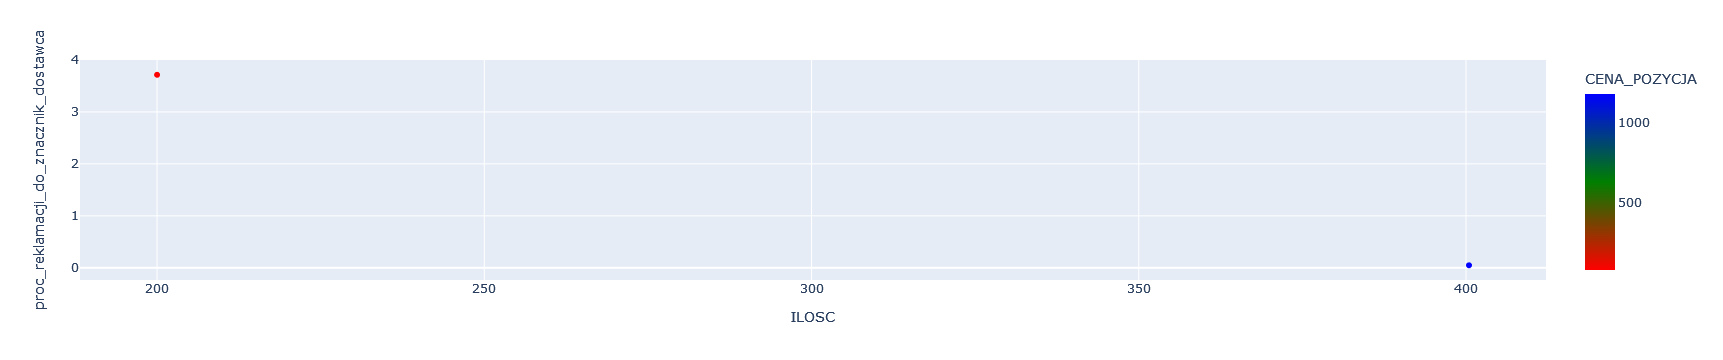

In [26]:
func_cluster(df_fi_sell, 'TAŚMY', 'OUTLET')

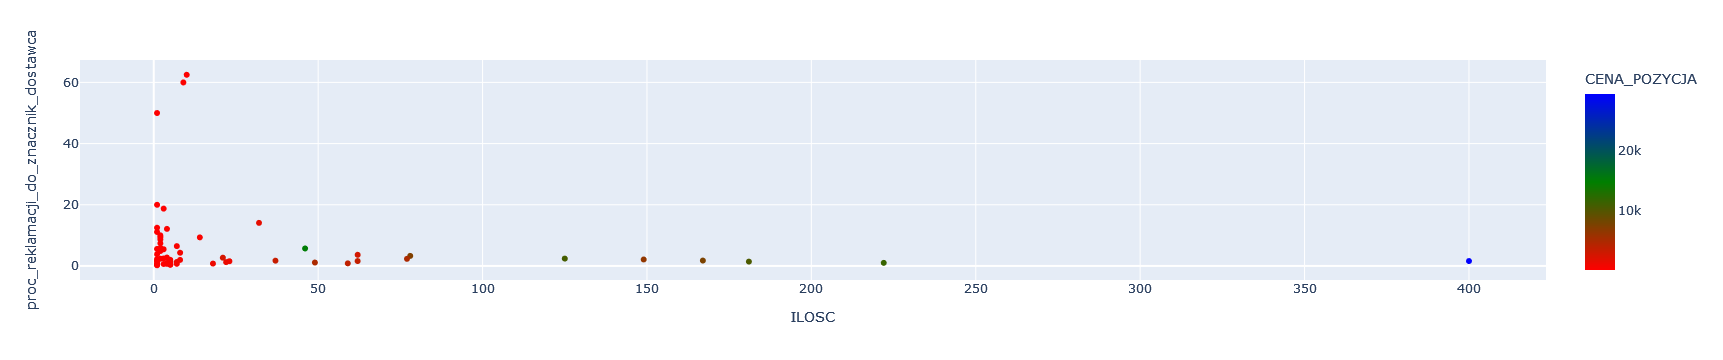

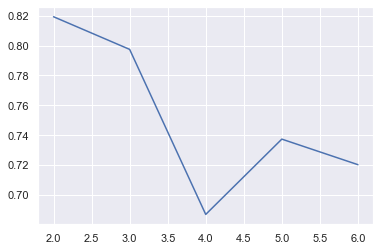

,NAZWA_ZNACZNIK,ANALIT02,DOSTAWCA,pred_cluster
312,CERAMIKA,LIKWIDACJA,,0
322,CERAMIKA,LIKWIDACJA,6788,0
355,CERAMIKA,LIKWIDACJA,10863,0
359,CERAMIKA,LIKWIDACJA,10872,0
360,CERAMIKA,LIKWIDACJA,10875,0
...,...,...,...,...
620,CERAMIKA,LIKWIDACJA,H76950,0
622,CERAMIKA,LIKWIDACJA,I16019,0
629,CERAMIKA,LIKWIDACJA,J24700,1
630,CERAMIKA,LIKWIDACJA,J25206,0


In [46]:
func_cluster(df_fi_sell, 'CERAMIKA', 'LIKWIDACJA', 1)

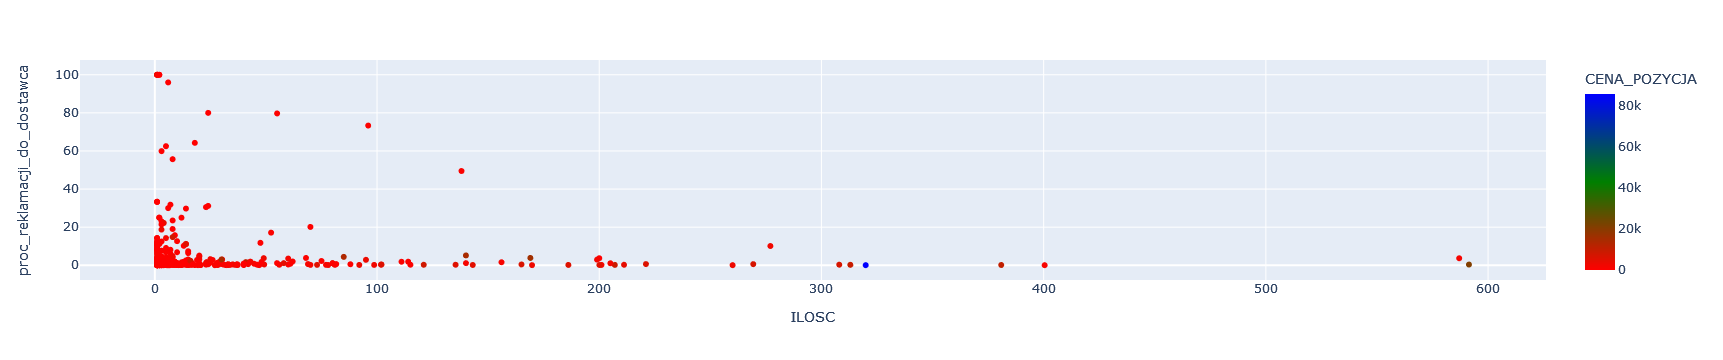

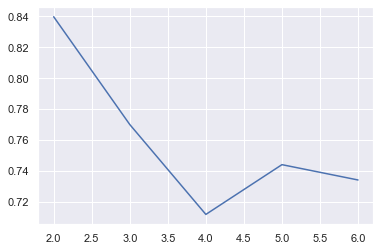

In [28]:
func_cluster(df_fi_sell, '', 'OUTLET',1)

## sprzedaz outlet vs wyslanie towarow na outlet z f56

roznica w cenach miedzy sprzedaza detaliczna a sprzedaza w outlecie

In [163]:
def func_procentowa_roznica_cen(df, group, save):
    df_total=df.loc[~df['ANALIT01'].isin(['OU','FE'])].groupby(group).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                                                     'ILOSC_SUM':'sum'})
    df_ou=df.loc[df['ANALIT01']=='OU'].groupby(group).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                                                     'ILOSC_SUM':'sum'})
    df_total['sr_cena_brutto_salon_total']=df_total['WARTSB_SUM_BRUTTO_SALON']/df_total['ILOSC_SUM']
    df_ou['sr_cena_brutto_salon_ou']=df_ou['WARTSB_SUM_BRUTTO_SALON']/df_ou['ILOSC_SUM']
    df_total=df_total.reset_index()
    df_ou=df_ou.reset_index()
    df=df_ou[group+['sr_cena_brutto_salon_ou']].merge(df_total[group+['sr_cena_brutto_salon_total']],
                                                                           how='outer',
                                                                           on=group)
    df['jaka_roznica_procentowa']=round((df['sr_cena_brutto_salon_ou']-df['sr_cena_brutto_salon_total'])/df['sr_cena_brutto_salon_total']*100, 1)
    df=df.loc[df['jaka_roznica_procentowa'].notnull()].sort_values(by='jaka_roznica_procentowa')
    if save=='zapisz':
        if 'KOD_TEMA' in group:
            func_slownik_nazwa_rodzaj(df).to_excel(path_to_catalog+'tabele_wyniki\procentowa_roznica_cen_'+'_'.join(group)+'.xlsx')
        else:
            df.to_excel(path_to_catalog+'tabele_wyniki\procentowa_roznica_cen_'+'_'.join(group)+'.xlsx')
    else:
        display(df.loc[df['jaka_roznica_procentowa'].notnull()].sort_values(by='jaka_roznica_procentowa'))

In [162]:
func_procentowa_roznica_cen(df_sell, ['NAZWA_ZNACZNIK','KOD_TEMA'],
                           'zapisz')

In [164]:
func_procentowa_roznica_cen(df_sell, ['NAZWA_ZNACZNIK'],
                           'zapisz')

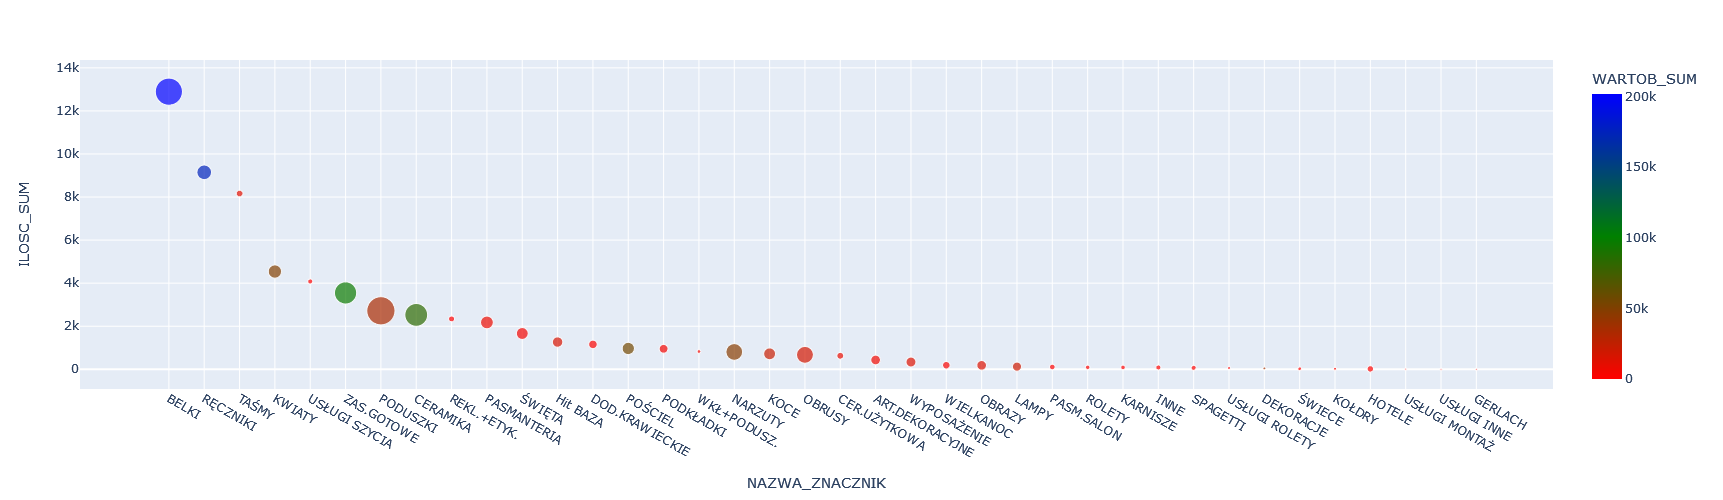

In [18]:
px.scatter(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='ILOSC_SUM', ascending=False),
           x='NAZWA_ZNACZNIK',
           color='WARTOB_SUM',
           y='ILOSC_SUM',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

In [13]:
df_sell.groupby('ANALIT01').agg({'WARTOB_SUM':'sum'}).sort_values(by='WARTOB_SUM', ascending=False)

,WARTOB_SUM
ANALIT01,
00,5.330691e+07
SI,1.207249e+07
,9.910097e+06
FR,8.717820e+06
SW,8.671142e+06
SF,2.685968e+06
OU,9.427402e+05
FE,4.100300e+02


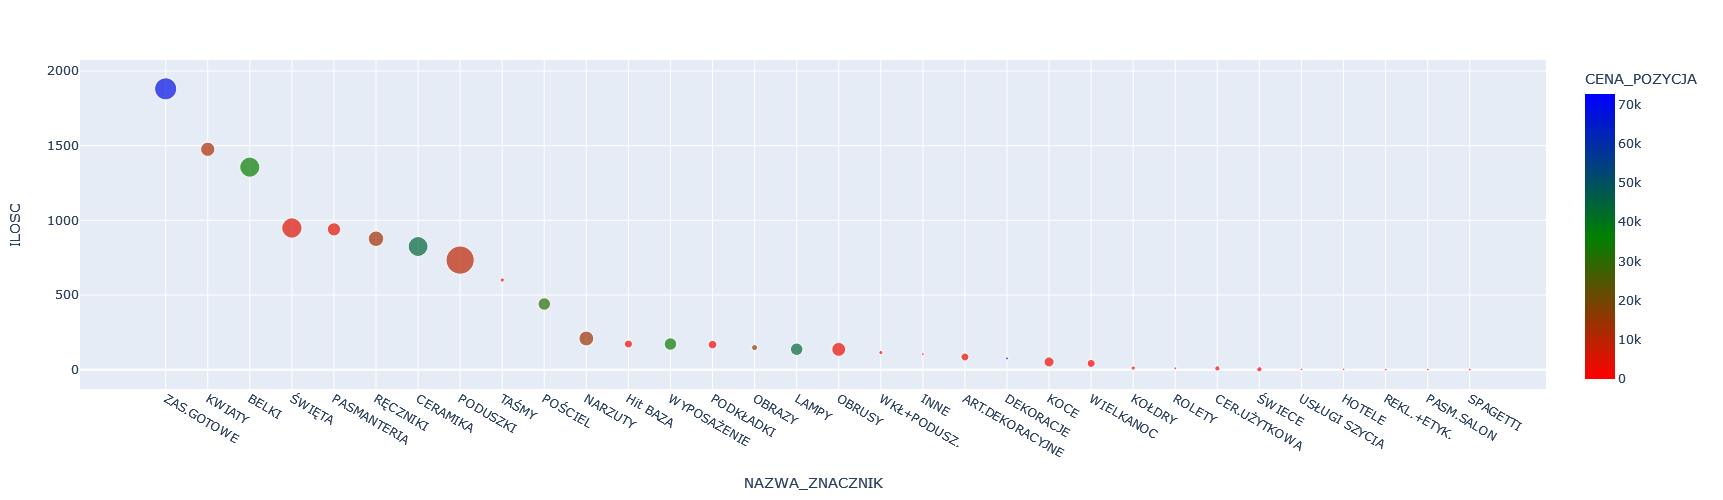

In [19]:
px.scatter(df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='ILOSC', ascending=False),
           x='NAZWA_ZNACZNIK',
           color='CENA_POZYCJA',
           y='ILOSC',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

<AxesSubplot:xlabel='NAZWA_ZNACZNIK'>

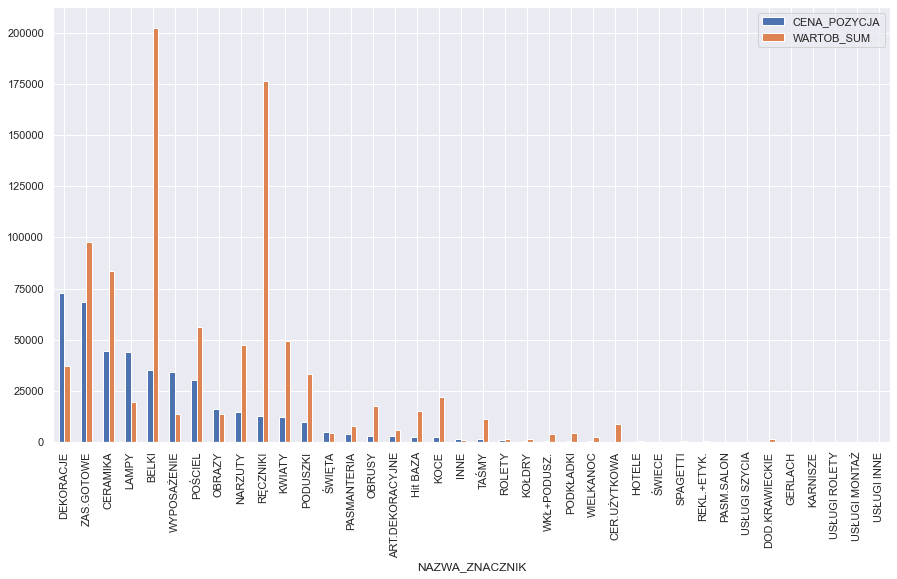

In [19]:
df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False).\
merge(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
how='outer',
on='NAZWA_ZNACZNIK')[['NAZWA_ZNACZNIK','CENA_POZYCJA','WARTOB_SUM']].set_index('NAZWA_ZNACZNIK').plot(kind='bar')

In [15]:
df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False).\
merge(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
how='outer',
on='NAZWA_ZNACZNIK')

,NAZWA_ZNACZNIK,CENA_POZYCJA,ILOSC,TRZY_x,WARTOB_SUM,ILOSC_SUM,TRZY_y
0,DEKORACJE,72649.383093,75.41,1.0,37148.62,42.000000,2
1,ZAS.GOTOWE,68623.581900,1885.00,52.0,97579.46,3569.650000,93
2,CERAMIKA,44314.366200,826.00,42.0,83695.54,2538.000000,98
3,LAMPY,44109.189900,138.00,17.0,19635.24,123.000000,16
4,BELKI,35380.904613,1356.51,43.0,202318.45,12920.991566,139
5,WYPOSAŻENIE,34194.922500,172.00,17.0,13546.70,340.000000,20
6,POŚCIEL,30425.169300,440.00,17.0,56063.72,973.000000,30
7,OBRAZY,16221.904200,148.00,4.0,13856.35,184.000000,18
8,NARZUTY,14699.701200,217.00,24.0,47618.77,811.000000,53
9,RĘCZNIKI,12810.548400,879.00,26.0,176142.85,9197.000000,41


# inne

In [15]:
# df_szac_bez_duplikatow=pd.DataFrame()
# brak_zmiany_ceny=0
# zmiana_ceny=0
# ind_zmiana_ceny=[]
# for fakt in tqdm(df_szac['FAKTURA'].unique()):
#     for nazwa in df_szac.loc[df_szac['FAKTURA']==fakt]['NAZWA1_BEZ_F'].unique():
#         if len(df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa])>1:
#             ind=df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa].index
#             if df_szac.loc[ind[0], 'CENA_Z1']!=df_szac.loc[ind[1], 'CENA_Z2']:
#                 zmiana_ceny+=1
#                 ind_zmiana_ceny=np.append(ind_zmiana_ceny, ind)
#             else: brak_zmiany_ceny+=1
#         else: continue


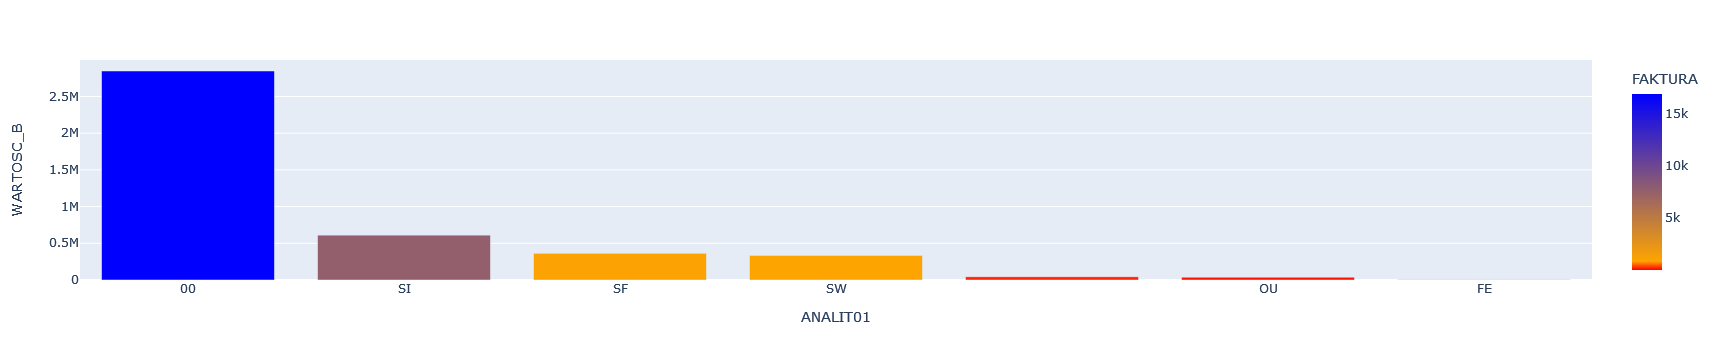

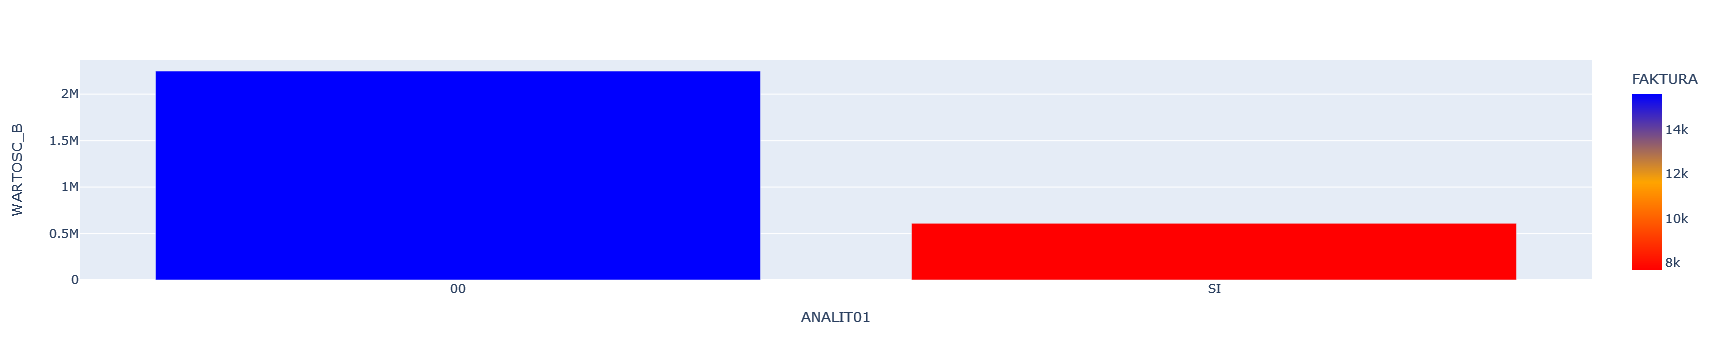

In [9]:
fig=px.bar(df_ff.groupby('ANALIT01').agg({'FAKTURA':'nunique',
                                               'WARTOSC_B':'sum'}).sort_values(by='WARTOSC_B', ascending=False).reset_index(),
           x='ANALIT01',
           y='WARTOSC_B',
           color='FAKTURA',
          color_continuous_scale=[[0,'red'],[0.05,'orange'],[1,'blue']])
fig.show()
fig=px.bar(df_ff.loc[df_ff['FAKTURA_FK']!=' '].groupby('ANALIT01').agg({'FAKTURA':'nunique',
                                                                           'WARTOSC_B':'sum'}).sort_values(by='WARTOSC_B', ascending=False).reset_index(),
           x='ANALIT01',
           y='WARTOSC_B',
           color='FAKTURA',
          color_continuous_scale=[[0,'red'],[0.5,'orange'],[1,'blue']])
fig.show()

In [28]:
100-2.25/2.85*100

21.05263157894737

In [19]:
df_ff['FAKTURA_FK']

0                    
1                    
2                    
3                    
4                    
             ...     
30651                
30652    KVSI00048042
30653    KV0000128896
30654    KV0000128912
30655                
Name: FAKTURA_FK, Length: 26878, dtype: object

In [10]:
df_ff.groupby('ANALIT01').agg(faktura_ff=('FAKTURA','nunique'),
                                wartosc_b_ff=('WARTOSC_B','sum')).sort_values(by='wartosc_b_ff', ascending=False).merge(
df_fi.groupby('ANALIT01').agg(faktura_fi=('FAKTURA','nunique'),
                                wartosc_b_fi=('CENA_POZYCJA','sum')),
how='outer',
left_index=True, right_index=True)

,faktura_ff,wartosc_b_ff,faktura_fi,wartosc_b_fi
ANALIT01,,,,
,190.0,43045.31,363.0,1.503429e+05
00,16914.0,2846325.18,17215.0,7.881812e+06
FE,17.0,2178.96,577.0,1.782596e+05
LI,NaN,NaN,1829.0,2.361223e+05
OU,107.0,38359.28,3112.0,4.218893e+05
SF,1057.0,364917.56,24.0,9.515354e+03
SI,7675.0,611520.78,NaN,NaN
SW,918.0,334284.56,32.0,2.302440e+04


In [11]:
display(df_ff.agg(faktura_ff=('FAKTURA','nunique'),
                                wartosc_b_ff=('WARTOSC_B','sum')))
display(df_fi.agg(faktura_fi=('FAKTURA','nunique'),
                                wartosc_b_fi=('CENA_POZYCJA','sum')))
# how='outer',
# left_index=True, right_index=True)

,FAKTURA,WARTOSC_B
faktura_ff,26878.0,NaN
wartosc_b_ff,NaN,4240631.63


,FAKTURA,CENA_POZYCJA
faktura_fi,23152.0,NaN
wartosc_b_fi,NaN,8.900965e+06


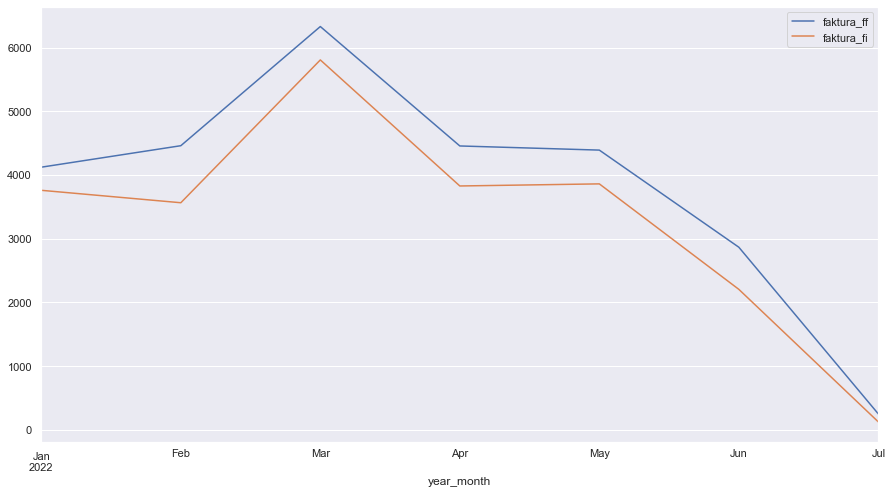

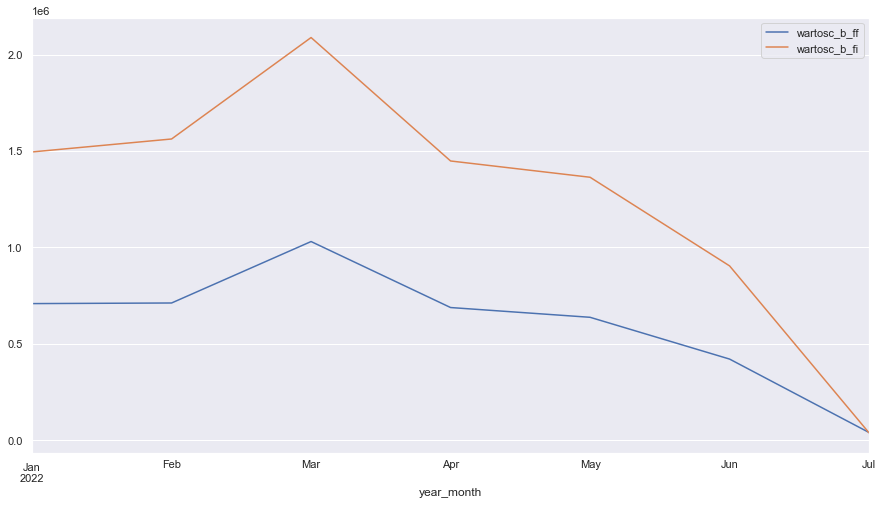

In [14]:
df_ff.groupby('year_month').agg(faktura_ff=('FAKTURA','nunique')).merge(
df_fi.groupby('year_month').agg(faktura_fi=('FAKTURA','nunique')),
how='outer',
left_index=True, right_index=True).plot()
plt.show()
df_ff.groupby('year_month').agg(wartosc_b_ff=('WARTOSC_B','sum')).merge(
df_fi.groupby('year_month').agg(wartosc_b_fi=('CENA_POZYCJA','sum')),
how='outer',
left_index=True, right_index=True).plot()
plt.show()

In [49]:
df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N']
df_slownik=func_add_znacznik(df_slownik)

In [47]:
df_slownik['KOD_PRODUC'].nunique()

927

In [48]:
df_slownik.groupby('TRZY').agg({'KOD_TEMA':'nunique',
                               'KOD_PRODUC':'unique'}).sort_values(by='KOD_TEMA', ascending=False)#.head(50)

,KOD_TEMA,KOD_PRODUC
TRZY,,
,44911,[ ]
EUR,6096,[ ]
BIS,4744,[ ]
XMH,4115,[ ]
QIN,3160,[ ]
...,...,...
U08,1,[ ]
AJ,1,[ ]
L25,1,[ ]


In [38]:
df_slownik.loc[df_slownik['TRZY']=='EUR']

,RECNO,IS_DELETED,NAZWA,RODZAJ,KOD_TEMA,KOD_TEMA_W,KOD_TEMA_K,FUN_KW,ZNACZNIK,NR_ZAKL_P,CENA_Z,PCENA_Z,CENA,CENA_D,GRUPA,PODGRUPA,VAT_P,VAT_R,VAT_N,SWW,PKWIU,OST_PRZ,OST_FAKT,MIN_ZAM,IL_MIN,IL_MAX,DZIENNY_R,DZIENNY_RC,W_ZGRZEWCE,SZTUK_KART,W_WARSTWIE,W_PALECIE,SUMA_DNI,ILOSC,ZALECAM,ILOSC_MAG,DATA_PRZY,DOSTAWCA,KOD_PASEK,ILOSC_II,JM,LOKACJA,KOD_HS,ILMAX_LOKW,CENA_F,CENA_P,CENA_S,WSPC_H,WSPC_D,WSPC_S,WSPC_P,DATA_PROM,ILOSC_PROM,DATA_WPISU,DATA_ARCH,OPER_ARCH,TYP_TOWARU,OPIS,ATEST,RODZ_PAKOW,BLOK_SPRZ,BLOK_ODDZ,KATEGORIA,POZYC_W_GR,DNI_WAZN,GRAMATURA,WAGA_BRUT,WAGA_ODC,SZER_KART,DLG_KART,WYS_KART,WYS_WARSTW,BLOK_MARZ,BL_ZM_AKT,PODZ_LUZ,ZAOK_ZAMD,KOD_PROMOC,TYP_TOW2,STATUS_I,DATA_KAT,TYP_FILI,LITRAZ,BL_ZM_CSP,AKTYWNOSC,ZAM_DOST,CENA_X,CENA_X2,CENA_X3,CENA_X4,ID_POZ_KOL,TOW_JEDNOR,CENA_WAL,CENA_WAL2,KOD_PRODUC,TYP_OPAK,RODZ_OPAK,KOD_PCN,KOD_KR,CLO,OPIS_TOW,NAZWA_INT,OPIS_INT,TOP10,TOP10D,KOLEJN_INT,CECH_INT01,CECH_INT02,CECH_INT03,CECH_INT04,CECH_INT05,CECH_INT06,KONTO_P,DOP_ODCHKG,CECH01,CECH02,CECH03,CECH04,CECH05,CECH06,CECH07,CECH08,CECH09,CECH10,KOLEKCJA,ROZMIAR,KOD_KOLOR,TOW_KURCZ,TOW_WZOR,TOW_RAPORT,GRAM_MATER,PROBNIK,SYMBOL_IMP,NAZWA_IMP,SKLAD_TOW,KANAL_DYST,PARAM_TECH,P_WYDR_ZUZ,ROZR_LOKAC,IE$0,IE$1,IE$2,IE$3,IE$4,IE$5,IE$6,IE$7,NAZWANAFAK,REKL_TOW,DATA_1PRZ,DATA_1PRZS,DATA_1PRZA,DATA_1PRZB,NR_CENNCZ,KOR_WYMIAR,NAZWA_KAT,MIN_PPAL,KOD_METKI,NR_ET_PRAN,MIN_UPUST,MAX_UPUST,NADZOR,NAZWA_M,RODZAJ_M,NAZWA_IN,RODZAJ_IN,SRCENA_Z,CECHPWZ,DNI_WAZN_S,DNI_WAZN_P,KOD_KUPCA,KOD_ZAOPAT,MARKA_PROD,PODPOWIADA,MM_SF,TYP_ROZM,SEZON,WZOR,CENA_AKCYZ,PLAN_CEZAR,KOD_KRES,STAN_KODPL,W_OPAK,GRAM_GSM,POZYC_W_ZN,IL_UZUP_JM,CZY_MPP,BLOK_MODUL,KOD_GTU,KOD_CN,KOD_PROC,TRZY,CENA_11,CENA_12,CENA_13,CENA_14,CENA_15,GRAM_CUK,GRAM_KOF,GRAM_TAU,GRAM_GUA,OPLAT_CUK,OPLAT_ALK,REALOK_BW,ZALEC_LUZ,SUBST_SLO,UD_SOK_OW,ROZTW_WE,WAG_N_PAK,TEMP_MIN,TEMP_MAX,DR_DOD_OPT,PMARKA_PRO,PLINIA_PRO,KOD_BLOZ,ZALACZNIK,DATA_VAT_N,KNTR_DWAZN
158,202,N,WYROBY GOTOWE,,27037,0,0,,99,0,"2,78",0,5,"11,9",99,0204,23,23,0,,,0,,0,0,0,0,5,0,0,0,0,0,0,0,0,12/01/01,8097,5908110000635,0,7,,,0,"5,5","11,9",0,0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,,0,,,0,,,0,0,0,0,0,0,0,0,0,0,,,,0,,,12/01/01,,0,,,,0,0,"7,4","1,06",,N,0,0,,,,5407699000,PO,0,,,,1,0,0,,,,,,,,0,,,,,,,,,0,,,,,,,,,,,,,,,,,WYROBY GOTOWE,99WYROBY GOTOWE,99WYROBY GOTOWE,27037,WYROBY GOTOWE,99WYROBY GOTOWE,99WYROBY GOTOWE,5908110000635,,,12/01/01,12/01/01,12/01/01,12/01/01,,,,0,,,,,,,,,,0,,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,54076990,,EUR,"5,5",0,0,0,0,0,0,0,0,0,0,,,,,,0,0,0,,,,,,12/01/01,
222,284,N,ZA/AXEL/B+BEŻ,140X250 P/9166,34441,0,0,,3,0,"16,67",0,30,"83,9",3,0115,23,23,0,,,0,,0,0,0,30,30,0,0,0,0,0,0,0,0,12/01/01,2362,5900811646723,0,2,,,0,33,"83,9",71,0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,L,0,,,0,,,0,0,700,750,0,0,0,0,0,3,,,,0,,,12/01/01,,0,,,,0,0,"55,4","6,31",,N,0,0,,,,6303929090,,0,,,,0,0,0,,,,,,,,0,,,N,,,,,,3,011,,168,004,,,,,,,,100% POLIESTER,,,,,ZA/AXEL/B+BEŻ 140X250 P/9166,3ZA/AXEL/B+BEŻ 140X250 P/9166,3ZA/AXEL/B+BEŻ 140X250 P/9166,34441,ZA/AXEL/B+BEŻ 140X250 P/9166,3ZA/AXEL/B+BEŻ 140X250 P/9166,3ZA/AXEL/B+BEŻ 140X250 P/9166,5900811646723,,,12/01/01,12/01/01,12/01/01,12/01/01,,,ZASŁONA GOTOWA EUROFIRANY,0,,,,,,,,,,0,,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,63039290,,EUR,33,0,0,0,0,0,0,0,0,0,0,,,,,,0,0,0,,,,,,12/01/01,
223,285,N,ZA/AXEL/B+CZER,140X250 P/9166,34442,0,0,,3,0,"16,67",0,30,"83,9",3,0115,23,23,0,,,0,,0,0,0,30,30,0,0,0,0,0,0,0,0,12/01/01,2362,5900811646730,0,2,,,0,33,"83,9",71,0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,L,0,,,0,,,0,0,700,750,0,0,0,0,0,3,,,,0,,,12/01/01,,0,,,,0,0,"55,4","6,31",,N,0,0,,,,6303929090,,0,,,,0,0,0,,,,,,,,0,,,N,,,,,,3,011,,168,005,,,,,,,,100% POLIESTER,,,,,ZA/AXEL/B+CZER 140X250 P/9166,3ZA/AXEL/B+CZER 140X250 P/9166,3ZA/AXEL/B+CZER 140X250 P/9166,34442,ZA/AXEL/B+CZER 140X250 P/9166,3ZA/AXEL/B+CZER 140X250 P/9166,3ZA/AXEL/B+CZER 140X250 P/9166,5900811646730,,,12/01/01,12/01/01,12/01/01,12/01/01,,,ZASŁONA GOTOWA EUROFIRANY,0,,,,,,,,,,0,,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,63039290,,EUR,33,0,0,0,0,0,0,0,0,0,0,,,,,

# polaczenie z baza (potrzebne haslo do testow)

In [23]:
import cx_Oracle
#cx_Oracle.init_oracle_client(lib_dir=r"C:\oracle_python\instantclient_19_9")
try:
    host = '192.168.0.206'
    port = 1521
    SID = 'orcl'
    
    dsn = cx_Oracle.makedsn(host, port, SID)
    
    connection = cx_Oracle.connect(user="EF_KG",
                                  password='HgmD5U$CcC',
                                  dsn=dsn,
                                   encoding="UTF-8")

    # show the version of the Oracle Database
    print(connection.version)
    
    query = """SELECT * 
           FROM HURT00.GRUP_RCP"""
    df_ora = pd.read_sql(query, con=connection)

except cx_Oracle.Error as error:
    print(error)
finally:
    # release the connection
    if connection:
        connection.close()


11.2.0.4.0


In [21]:
connection

<cx_Oracle.Connection to EF_KG@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=192.168.0.206)(PORT=1521))(CONNECT_DATA=(SID=orcl)))>

In [24]:
df_ora

,RECNO,IS_DELETED,KOD_GR_RCP,GR_OPIS,FILIA
0,27,N,K,KOREKTY,00
1,28,N,P I,PRACOWNIA I ZMIANA,00
2,29,N,KUP,KUPONY,00
3,30,N,PR,PRÓBNIKI,00
4,35,N,C5,SALON C5,C5
...,...,...,...,...,...
82,83,N,A-L4,DŁUGA NIEOBECNOŚĆ,00
83,88,N,A-ZAR,ADMINISTRACJA ZARZĄD,00
84,5,N,ZI Ś,ZMIANA I ŚWIĘTA,00
85,33,N,M,MONTAŻYŚCI/KIEROWCY,00
